libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from datetime import datetime

groups (uni, gruppo) & dataset loading

In [2]:
group = 'gruppo'
df = pd.read_csv('calcetti_' + group + '.csv')

inputs

In [3]:
game_date=datetime(2024,9,6)
game_id=24
game_location="Pineta"
#game_type='5v5'

data = {
    'NAMES' : ['Samu','Romi','Pale','Manu','Tommi','Fox','Damiano','Turco','Magic','Kevin'],
    'TEAMS' : [1,1,1,1,1,2,2,2,2,2],
    'GOALS' : [2,2,2,0,0,3,3,0,4,1],
    'OWN GOALS' : [0,0,0,0,0,0,0,0,0,0],
    #'ASSISTS' : [0,2,1,0,0,0,0,4,0,4]
}

data=pd.DataFrame(data)

automatic stuff

In [4]:
team_1_goals=data['GOALS'][data['TEAMS']==1].sum()+data['OWN GOALS'][data['TEAMS']==2].sum()
team_2_goals=data['GOALS'][data['TEAMS']==2].sum()+data['OWN GOALS'][data['TEAMS']==1].sum()

#game identification
data['DATE']=game_date
data['GAME ID']=game_id
data['LOCATION']=game_location
#data['GAME TYPE']=game_type

#goals and results 
data.loc[data['TEAMS'] == 1, 'TEAM GOALS SCORED']=team_1_goals
data.loc[data['TEAMS'] == 2, 'TEAM GOALS SCORED']=team_2_goals
data.loc[data['TEAMS'] == 1, 'TEAM GOALS CONCEEDED']=team_2_goals
data.loc[data['TEAMS'] == 2, 'TEAM GOALS CONCEEDED']=team_1_goals
data['GOALS DIFFERENCE']=data['TEAM GOALS SCORED']-data['TEAM GOALS CONCEEDED']
data.loc[data['TEAM GOALS SCORED']>data['TEAM GOALS CONCEEDED'],'W/D/L']='W'
data.loc[data['TEAM GOALS SCORED']<data['TEAM GOALS CONCEEDED'],'W/D/L']='L'
data.loc[data['TEAM GOALS SCORED']==data['TEAM GOALS CONCEEDED'],'W/D/L']='D'

appending the new data and storing the new dataset

In [5]:
check=df[df['GAME ID']==game_id]
if check.empty:
    df=pd.concat([df, data], ignore_index=True)
    df=df.sort_values(by=['GAME ID','TEAMS'])
    df.to_csv('/Users/samueleborsini/File/Varie/calcetti_' + group + '.csv', index=False)
else:
    print('Game ' + f'{game_id} is already in the whole dataset!')

updating the data frame and the pdf of top scorers

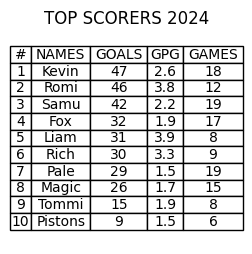

In [6]:
# updating the df of the top scorers
year=pd.to_datetime(df[df['GAME ID']==df['GAME ID'].max()]['DATE'].values[0]).year
df_ay=df[(pd.to_datetime(df['DATE'])>datetime(year-1,12,31)) & (pd.to_datetime(df['DATE'])<datetime(year+1,1,1))]

grouped = df_ay.groupby('NAMES')
ts=pd.DataFrame()
ts['GOALS']=grouped['GOALS'].sum()
ts['#']=1
ts['GAMES'] = grouped['NAMES'].count()
ts['GPG'] = ts['GOALS']/ts['GAMES']
#ts=ts.drop('GAMES', axis=1)
ts=ts.sort_values(by=['GOALS','GPG'], ascending=[False,False])

i=1
j=i
g=ts['GOALS'].max()
for name in ts.index:
    if ts['GOALS'][name] != g:
        j=i
    g = ts['GOALS'][name]
    ts.loc[ts.index==name,'#'] = j
    i+=1

ts=ts.reset_index()
ts['GPG']=ts['GPG'].round(1)
ts=ts[['#','NAMES','GOALS','GPG','GAMES']]
ts=ts[ts['GOALS']!=0]
ts=ts[ts.index<10]

# updating the pdf of the top scorers
fig, ax = plt.subplots(figsize=(3,2.75))
ax.axis('tight')
ax.axis('off')
ax.set_title(f'TOP SCORERS {year}')

tab = ax.table(cellText=ts.values, colLabels=ts.columns, loc='center', cellLoc='center')

tab.auto_set_column_width(col=list(range(len(ts.columns))))

pdf_pages = PdfPages('top_scorers_' + group + '.pdf')
pdf_pages.savefig(fig, bbox_inches='tight')
pdf_pages.close()


stats

In [7]:
# winning percentage
wins = pd.DataFrame()
wins['NAMES']=df_ay['NAMES'].copy()
wins['WINS']=0
wins.loc[df_ay['W/D/L']=='W','WINS']=1
wins.loc[df_ay['TEAMS']==3,'WINS']=np.nan
wins.drop(wins[wins['WINS'].isna()].index,inplace=True)
wins.reset_index(inplace=True,drop=True)
grouped = wins.groupby('NAMES')
wp=pd.DataFrame()
wp['W']=grouped['WINS'].sum()
wp['GAMES'] = grouped['NAMES'].count()
wp['WP'] = wp['W']/wp['GAMES']
wp['WP'] = wp['WP'].round(2)
wp=wp.sort_values(by=['WP'],ascending=[False])
wp=wp.drop('W',axis=1)
wp=wp[wp['GAMES']>=4]
wp=wp[['WP','GAMES']]
wp=wp.sort_values(by=['WP','GAMES'],ascending=[False,False])

print(wp)

# some stats
stats_pg = pd.DataFrame()
stats = pd.DataFrame()
grouped = df_ay.groupby('NAMES')
stats_pg['GAMES']=grouped['NAMES'].count()
stats['GAMES']=grouped['NAMES'].count()
stats_pg['GOALS']=grouped['GOALS'].sum()/stats['GAMES']
stats['GOALS']=grouped['GOALS'].sum()
stats_pg['PERCENTAGE GOALS']=grouped['GOALS'].sum()/grouped['TEAM GOALS SCORED'].sum()
stats_pg['TEAM GOALS SCORED']=grouped['TEAM GOALS SCORED'].sum()/stats['GAMES']
stats['TEAM GOALS SCORED']=grouped['TEAM GOALS SCORED'].sum()
stats_pg['TEAM GOALS CONCEEDED']=grouped['TEAM GOALS CONCEEDED'].sum()/stats['GAMES']
stats['TEAM GOALS CONCEEDED']=grouped['TEAM GOALS CONCEEDED'].sum()

stats_pg=stats_pg[stats_pg['GAMES']>=4]
stats=stats[stats['GAMES']>=4]
stats_pg['WINNING PERCENTAGE']=wp['WP']

# mates matrix
MM=pd.DataFrame(index=df['NAMES'].unique(), columns=df['NAMES'].unique())
MM=MM.fillna(0)
for id in df['GAME ID'].unique():
    a=df[df['GAME ID']==id]
    for name1 in a['NAMES'].unique():
        for name2 in a['NAMES'].unique():
            if a.loc[a['NAMES']==name1, 'TEAMS'].values[0]==a.loc[a['NAMES']==name2, 'TEAMS'].values[0]:
                MM[name1].loc[name2]=MM[name1].loc[name2]+1

           WP  GAMES
NAMES               
Damiano  1.00      4
Rich     0.67      9
Magic    0.57     14
Pale     0.56     18
Romi     0.55     11
Kevin    0.53     17
Liam     0.50      8
Pistons  0.50      6
Andri    0.50      4
Manu     0.50      4
Samu     0.39     18
Fox      0.38     16
Tommi    0.29      7
Lausdi   0.25      4
